# AR Model in TimeSeries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
import pandas.util.testing as tm

# DataSet of IceCream Production Data

In [20]:
def parser(s):
    """
    This function here is used in order to strip the date into the 
    Year-Month-Day format.
    """
    return datetime.strptime(s, '%Y-%m-%d')

In [21]:
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
production_ice_cream.rename('production', inplace = True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [22]:
#infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [23]:
# get data from 2010 only 
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

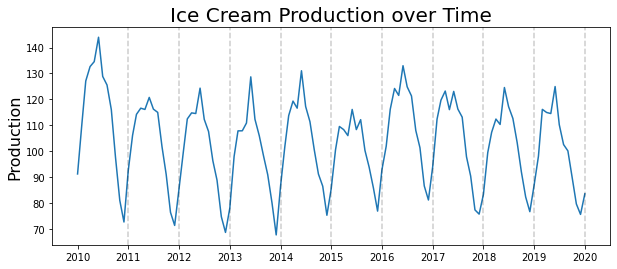

In [24]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Based on decaying ACF, we are likely dealing with an Auto Regressive process

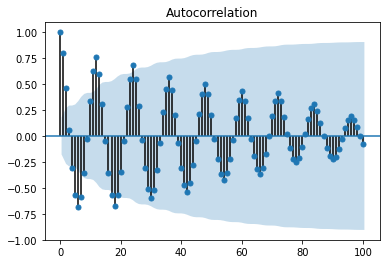

In [25]:
acf_plot = plot_acf(production_ice_cream, lags=100)

Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3

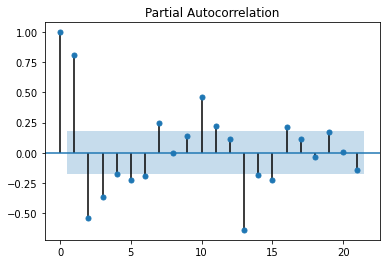

In [26]:
pacf_plot = plot_pacf(production_ice_cream)

#Train and Test

In [27]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR model

In [29]:
model = ARMA(train_data, order=(3,0))
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.12874960899353027


In [30]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Mon, 03 May 2021   AIC                            758.170
Time:                        08:12:00   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5743      1.809     57.265      0.000     100.029     107.119
ar.L1.production     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.production    -0.0523 

#So the AR(3) model is:

$\hat{y_t} = 103 + 1.04y_{t-1} - 0.05y_{t-2} - 0.40y_{t-3}$

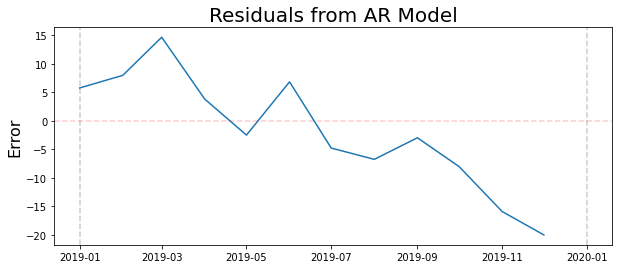

In [31]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

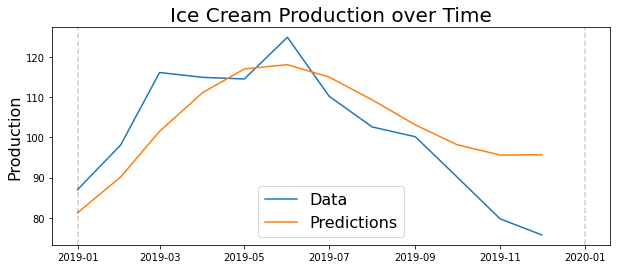

In [32]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [33]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


Mean Absolute Percent Error: 0.0895
Root Mean Squared Error: 9.884057997130114
